In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

In [30]:
df = pd.read_csv("data/housing.csv")

In [31]:
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [33]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


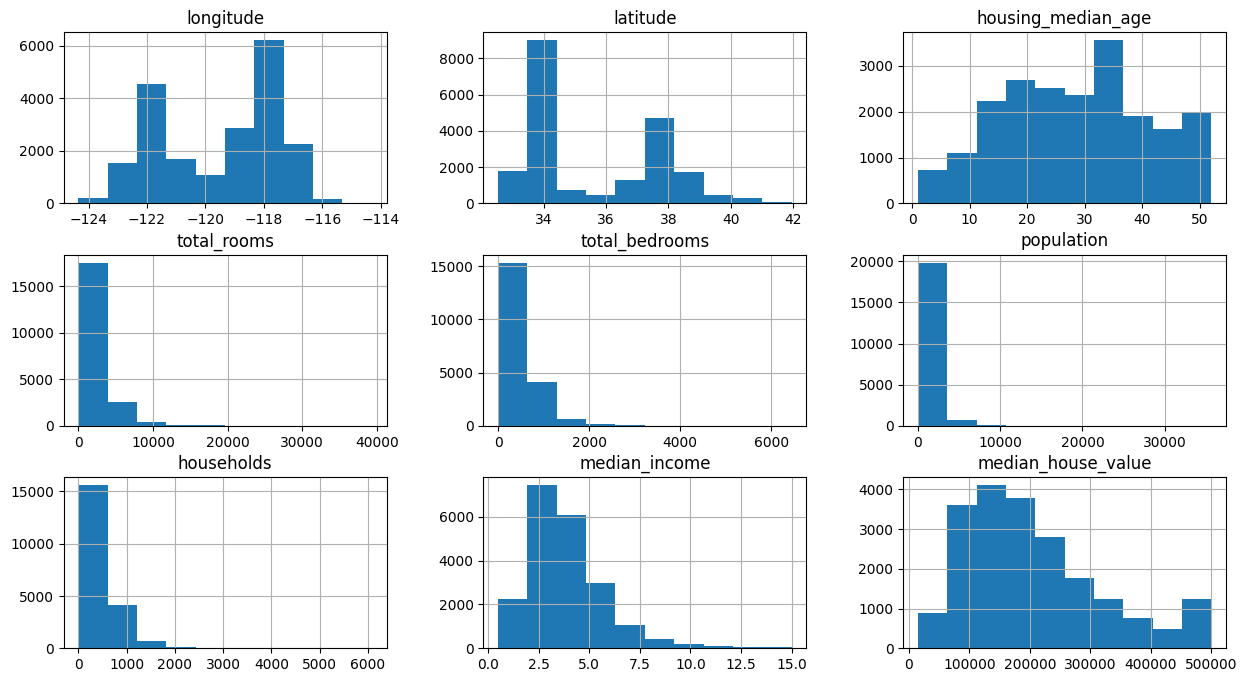

In [34]:
df.hist(figsize=(15, 8))
plt.show()

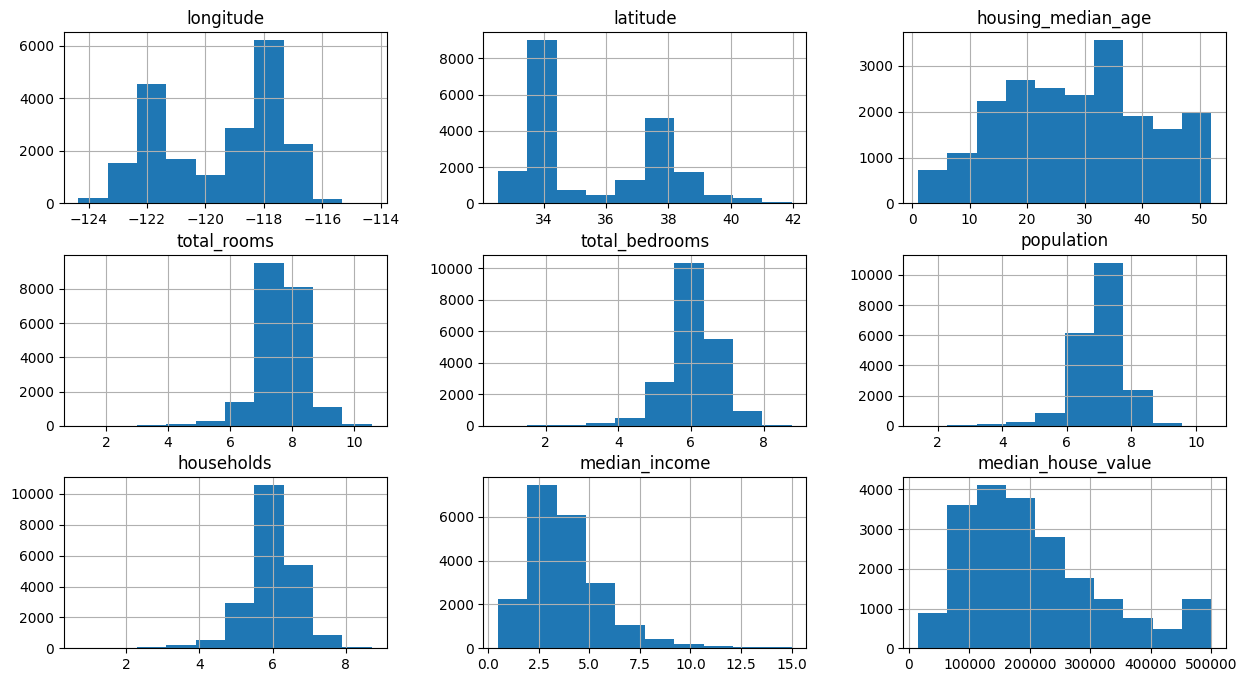

In [35]:
def scale_logarithmic(data, categories):
    for categorie in categories:
        data[categorie] = np.log(data[categorie] + 1)

scale_logarithmic(df, ["total_rooms", "total_bedrooms", "population", "households"])

df.hist(figsize=(15, 8))
plt.show()

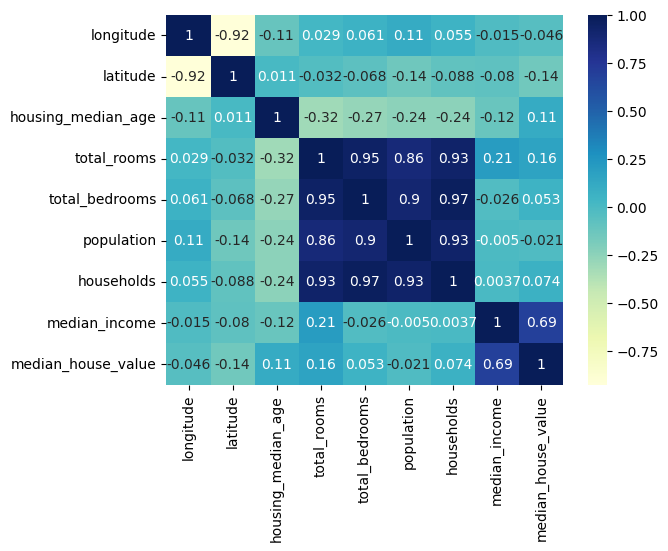

In [36]:
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

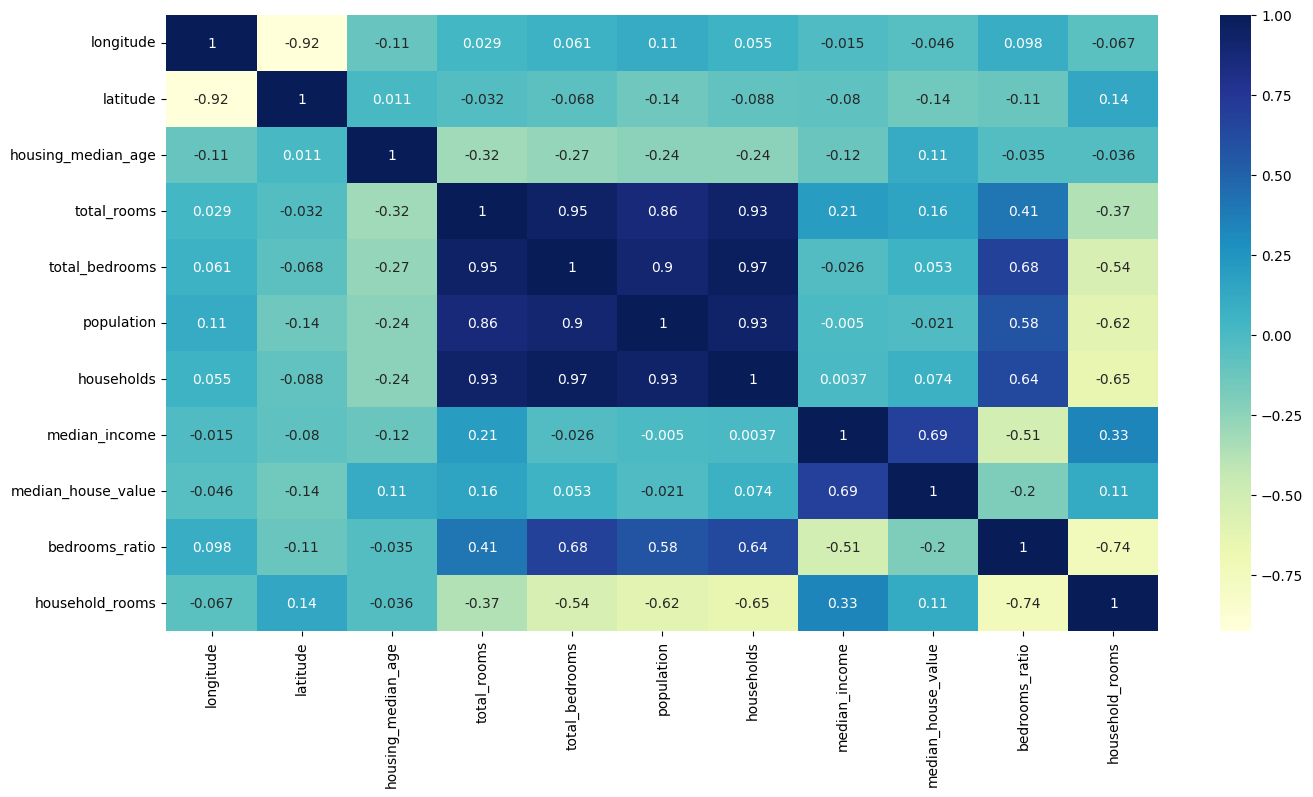

In [37]:
df["bedrooms_ratio"] = df["total_bedrooms"] / df["total_rooms"]
df["household_rooms"] = df["total_rooms"] / df["households"]

plt.figure(figsize=(16, 8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap="YlGnBu")
plt.show()

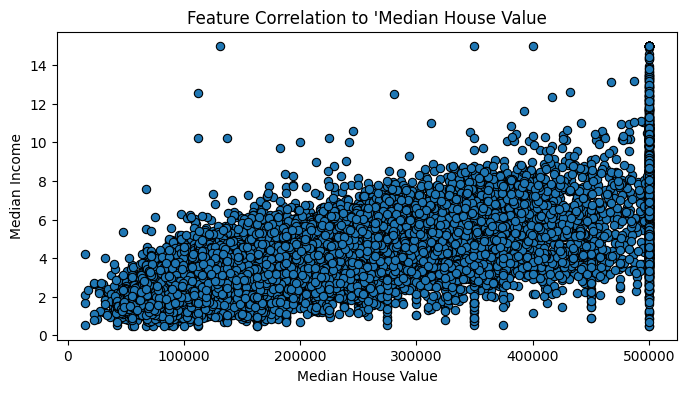

In [38]:
plt.figure(figsize=(8, 4))
plt.title("Feature Correlation to 'Median House Value")
plt.xlabel("Median House Value")
plt.ylabel("Median Income")
plt.scatter(df["median_house_value"], df["median_income"], edgecolors="black", linewidths=0.8, label="Median Income")

plt.show()

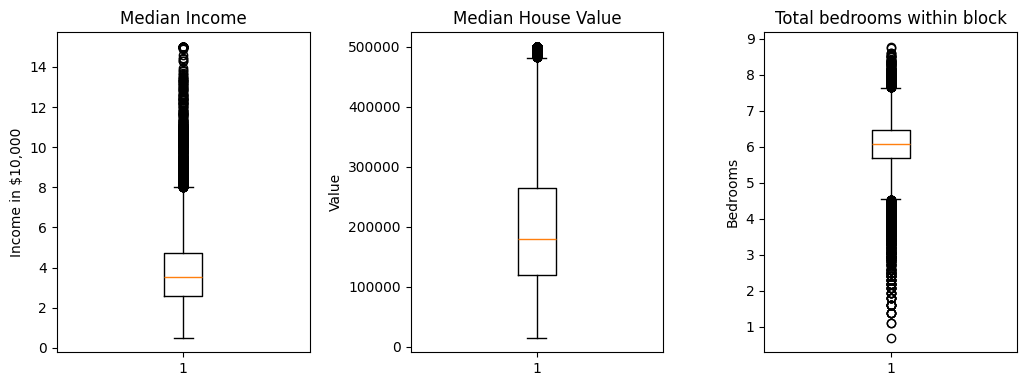

In [39]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.title("Median Income")
plt.ylabel("Income in $10,000")
plt.boxplot(df["median_income"])

plt.subplot(1, 3, 2)
plt.title("Median House Value")
plt.ylabel("Value")
plt.boxplot(df["median_house_value"])

plt.subplot(1, 3, 3)
plt.title("Total bedrooms within block")
plt.ylabel("Bedrooms")
plt.boxplot(df["total_bedrooms"].dropna())

plt.subplots_adjust(left=0.1, right=0.9, bottom=0.1, top=0.9, wspace=0.4, hspace=0.4)

plt.show()

In [40]:
df.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
bedrooms_ratio        207
household_rooms         0
dtype: int64

In [41]:
vals, counts = np.unique(df["ocean_proximity"], return_counts=True)
print(f"There are {len(counts)} distinct values in 'ocean_proximity': {[val for val in vals]}")

There are 5 distinct values in 'ocean_proximity': ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']


In [42]:
class TotalBedroomImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        imputed_X = X
        imputer = SimpleImputer(strategy="median")
        imputed_X["total_bedrooms"] = imputer.fit_transform(imputed_X[["total_bedrooms"]])
        imputer = SimpleImputer(strategy="median")
        imputed_X["bedrooms_ratio"] = imputer.fit_transform(imputed_X[["bedrooms_ratio"]])
        return imputed_X

In [43]:
class FeatureEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        transformed_X = X
        transformed_X = self.concat_encoded(transformed_X, "ocean_proximity", ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'])
        return transformed_X
    
    def concat_encoded(self, X, column, new_columns):
        encoder = OneHotEncoder()
        encoded = encoder.fit_transform(X[[column]])
        new_columns = new_columns[:encoded.shape[1]]
        tmp_df = pd.DataFrame(encoded.toarray(), columns=new_columns)
        tmp_df.index = X.index
        X = pd.concat([X, tmp_df], axis=1)
        return X

In [44]:
class FeatureDropper(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.drop(columns=["total_bedrooms", "households", "ocean_proximity", "population"])

In [45]:
pipeline = Pipeline([("totalBedroomImputer", TotalBedroomImputer()),
                     ("featureEncoder", FeatureEncoder()),
                     ("featureDropper", FeatureDropper())])

In [46]:
df_processed = pipeline.fit_transform(df)
df_processed

,longitude,latitude,housing_median_age,total_rooms,median_income,median_house_value,bedrooms_ratio,household_rooms,<1H OCEAN,INLAND,ISLAND,NEAR BAY,NEAR OCEAN
0,-122.23,37.88,41.0,6.781058,8.3252,452600.0,0.717813,1.399834,0.0,0.0,0.0,1.0,0.0
1,-122.22,37.86,21.0,8.867850,8.3014,358500.0,0.790429,1.260013,0.0,0.0,0.0,1.0,0.0
2,-122.24,37.85,52.0,7.291656,7.2574,352100.0,0.720313,1.407171,0.0,0.0,0.0,1.0,0.0
3,-122.25,37.85,52.0,7.150701,5.6431,341300.0,0.764097,1.325768,0.0,0.0,0.0,1.0,0.0
4,-122.25,37.85,52.0,7.395108,3.8462,342200.0,0.762444,1.329892,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,7.418181,1.5603,78100.0,0.798973,1.278530,0.0,1.0,0.0,0.0,0.0
20636,-121.21,39.49,18.0,6.548219,2.5568,77100.0,0.766205,1.380045,0.0,1.0,0.0,0.0,0.0
20637,-121.22,39.43,17.0,7.720905,1.7000,92300.0,0.801228,1.271340,0.0,1.0,0.0,0.0,0.0
20638,-121.32,39.43,18.0,7.528869,1.8672,84700.0,0.799078,1.285243,0.0,1.0,0.0,0.0,0.0


In [47]:
X = df_processed.drop(columns=["median_house_value"])
y = df_processed["median_house_value"]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, np.array(y), test_size=0.2, random_state=42)

# X_train, X_test, y_train, y_test = train_test_split(X, np.array(y), test_size=0.2, random_state=42)

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)

# scaler = StandardScaler()
# X_test = scaler.fit_transform(X_test)

## Linear Regression Model

In [48]:
model = LinearRegression()
model.fit(X_train, y_train)

model.score(X_test, y_test)

0.603010589837234

## Random Forest Model

In [49]:
forest = RandomForestRegressor()
forest.fit(X_train, y_train)
forest.score(X_test, y_test)

0.8111699680519943

In [50]:
forest = RandomForestRegressor()

param_grid = {
    'n_estimators': [200, 300, 400],
    'max_depth': [20, 30, 40],
    'min_samples_split': [2, 5]
}

grid_search = GridSearchCV(forest, param_grid, cv=5, scoring="neg_mean_squared_error", return_train_score=True, error_score="raise")
grid_search.fit(X_train, y_train)
grid_search.best_params_

{'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 400}

In [51]:
final_forest = grid_search.best_estimator_

In [52]:
final_forest.score(X_test, y_test)

0.8113872610425572

In [53]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer with one neuron for regression
])

model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)


Epoch 1/50
516/516 [==============================] - 2s 2ms/step - loss: 55998009344.0000 - val_loss: 54105264128.0000
Epoch 2/50
516/516 [==============================] - 1s 2ms/step - loss: 51772743680.0000 - val_loss: 46231502848.0000
Epoch 3/50
516/516 [==============================] - 1s 2ms/step - loss: 39952072704.0000 - val_loss: 31549161472.0000
Epoch 4/50
516/516 [==============================] - 1s 2ms/step - loss: 24594741248.0000 - val_loss: 17580103680.0000
Epoch 5/50
516/516 [==============================] - 1s 2ms/step - loss: 13636494336.0000 - val_loss: 10477746176.0000
Epoch 6/50
516/516 [==============================] - 1s 2ms/step - loss: 9223247872.0000 - val_loss: 8305610752.0000
Epoch 7/50
516/516 [==============================] - 1s 2ms/step - loss: 7859228672.0000 - val_loss: 7513982976.0000
Epoch 8/50
516/516 [==============================] - 1s 2ms/step - loss: 7251442688.0000 - val_loss: 7035693056.0000
Epoch 9/50
516/516 [==========================

In [58]:
nn_mse = model.evaluate(X_test, y_test)

forest_predictions = final_forest.predict(X_test)
forest_mse = mean_squared_error(y_test, forest_predictions)

print(f"Mean Squared Error (MSE) Neural Network:\t{nn_mse:_}")
print(f"Mean Squared Error (MSE) Random Forest:\t\t{forest_mse:_}")

129/129 [==============================] - 0s 2ms/step - loss: 4865957888.0000
Mean Squared Error (MSE) Neural Network:	4_865_957_888.0
Mean Squared Error (MSE) Random Forest:		2_471_598_265.404402
